# Flight Price Forecast - Momondo

## Table of Contents
- [Introduction](#Introduction)
- [Imports](#Imports)
- [Data Preprocessing](#Data-Preprocessing)
- [Linear Regression](#linear-regression)
- [Desition Tree](#Desion-Tree)
- [Gaussian Process Regression](#Gaussian-Process-Regression)
- [Random Forest](#Random-Forest)
- [GridSearchCV](#GridSearchCV)
- [KNN Regressor](#KNN-Regressor)
- [MLP Regressor](#MLPRegressor)
- [XG Boost Regressor](#XGBoost-Regressor)
- [Hist Gradient Boosting](#Hist-Gradient-Boosting)
- [Best Performance with Best Parameters](#Best-Performance-with-Best-Parameters)
- [Feature Importance](#Feature-Importance)
- [Conclustions](#Conclustion)


#### Introduction:

##### The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops. The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.

#### Random Forest, XGBoost, and HistGradientBoosting regressors demonstrated the strongest predictive performances, significantly outperforming basic linear models, while visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.

# Imports

In [81]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Data Preprocessing

In [83]:
# טענת הנתונים
df = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv')

# הצצה לנתונים
print(df.head())
print(df.info())

  Snap Date  Dep Date Return Date           Dep time Dep Company Stops  \
0  3/2/2025  3/3/2025    3/4/2025  7:25 pm – 9:40 pm     Vueling     0   
1  3/2/2025  3/3/2025    3/4/2025  3:15 pm – 5:45 pm     Vueling     0   
2  3/2/2025  3/3/2025    3/4/2025  7:25 pm – 9:40 pm     Vueling     0   
3  3/2/2025  3/3/2025    3/4/2025  2:05 pm – 4:25 pm     Vueling     0   
4  3/2/2025  3/3/2025    3/4/2025  2:05 pm – 4:25 pm     Vueling     0   

  Dep Duration From Airport Landing Airport          Back Time Back Company  \
0       1h 15m          LGW             ORY  2:10 pm – 2:25 pm      Vueling   
1       1h 30m          LHR             ORY  2:10 pm – 2:25 pm      Vueling   
2       1h 15m          LGW             ORY  5:25 pm – 5:30 pm      Vueling   
3       1h 20m          LGW             ORY  2:10 pm – 2:25 pm      Vueling   
4       1h 20m          LGW             ORY  5:25 pm – 5:30 pm      Vueling   

  Stops.1 Back Duration (Back Ticket) From Airport  \
0       0        1h 15m   

/var/folders/3b/jd8k5j055rx3c991jlh5x05h0000gn/T/ipykernel_72422/638179380.py:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv')


In [84]:
# 1. בדיקה שהעמודה קיימת
print(df.columns)

# 2. הצצה בכמה ערכים ראשונים
print(df['Price'].head(10))

# 3. בדיקת סוג העמודה
print("Column type:", df['Price'].dtype)

# 4. אם היא כבר float, אולי אין צורך בהחלפה. 
#    אם היא object/string, ננסה לנקות תווים.

df['Price'] = df['Price'].astype(str)  # ממיר הכל למחרוזת, אם עדיין לא
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = df['Price'].str.replace(',', '', regex=False)

# 5. בדיקת ערכים חריגים
unique_vals = df['Price'].unique()
print(unique_vals[:50])  # תצוגה של 50 ערכים ראשונים

# 6. המרה למספרים
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 7. בדיקת כמה NaN נוצרו
nan_count = df['Price'].isna().sum()
print("Number of NaN after conversion:", nan_count)

# אם יש NaN, מחליטים איך לטפל: להסיר שורות? למלא ערך ממוצע? וכו'
df = df.dropna(subset=['Price'])  # לדוגמה, הסרה של שורות בלי מחיר תקין


Index(['Snap Date', 'Dep Date', 'Return Date', 'Dep time', 'Dep Company',
       'Stops', 'Dep Duration', 'From Airport', 'Landing Airport', 'Back Time',
       'Back Company', 'Stops.1', 'Back Duration',
       '(Back Ticket) From Airport', '(Back Ticket) Landing Airport', 'Price',
       'Class'],
      dtype='object')
0    $116 
1    $115 
2    $129 
3    $116 
4    $129 
5    $129 
6    $129 
7    $115 
8    $130 
9    $129 
Name: Price, dtype: object
Column type: object
['116 ' '115 ' '129 ' '130 ' '123 ' '118 ' '139 ' '142 ' '143 ' '146 '
 '144 ' '147 ' '148 ' '150 ' '152 ' '154 ' '157 ' '156 ' '160 ' '163 '
 '166 ' '168 ' '164 ' '172 ' '161 ' '174 ' '175 ' '170 ' '181 ' '184 '
 '179 ' '169 ' '171 ' '182 ' '180 ' '155 ' '177 ' '131 ' '162 ' '183 '
 '196 ' '114 ' '126 ' '133 ' '127 ' '145 ' '132 ' '128 ' '125 ' '117 ']
Number of NaN after conversion: 2246


In [85]:
df.head()

,Snap Date,Dep Date,Return Date,Dep time,Dep Company,Stops,Dep Duration,From Airport,Landing Airport,Back Time,Back Company,Stops.1,Back Duration,(Back Ticket) From Airport,(Back Ticket) Landing Airport,Price,Class
0,3/2/2025,3/3/2025,3/4/2025,7:25 pm – 9:40 pm,Vueling,0,1h 15m,LGW,ORY,2:10 pm – 2:25 pm,Vueling,0,1h 15m,ORY,LHR,116.0,Economy
1,3/2/2025,3/3/2025,3/4/2025,3:15 pm – 5:45 pm,Vueling,0,1h 30m,LHR,ORY,2:10 pm – 2:25 pm,Vueling,0,1h 15m,ORY,LHR,115.0,Economy
2,3/2/2025,3/3/2025,3/4/2025,7:25 pm – 9:40 pm,Vueling,0,1h 15m,LGW,ORY,5:25 pm – 5:30 pm,Vueling,0,1h 05m,ORY,LGW,129.0,Economy
3,3/2/2025,3/3/2025,3/4/2025,2:05 pm – 4:25 pm,Vueling,0,1h 20m,LGW,ORY,2:10 pm – 2:25 pm,Vueling,0,1h 15m,ORY,LHR,116.0,Economy
4,3/2/2025,3/3/2025,3/4/2025,2:05 pm – 4:25 pm,Vueling,0,1h 20m,LGW,ORY,5:25 pm – 5:30 pm,Vueling,0,1h 05m,ORY,LGW,129.0,Economy


In [86]:
df['Snap Date'] = pd.to_datetime(df['Snap Date'])
df['Dep Date'] = pd.to_datetime(df['Dep Date'])
df['Return Date'] = pd.to_datetime(df['Return Date'])
df['dep_weekday'] = df['Dep Date'].dt.weekday  # ערך 0-6
df['dep_day'] = df['Dep Date'].dt.day         # ערך 1-31
df['dep_month'] = df['Dep Date'].dt.month     # ערך 1-12
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x>=5 else 0)

def convert_stops(stops):
    """ ממיר עצירות לטיפוס מספרי (0 עבור nonstop) """
    if isinstance(stops, str):
        stops = stops.lower().strip()  # מנקה רווחים וממיר לאותיות קטנות
        if "nonstop" in stops:
            return 0
        elif "stop" in stops:
            return int(stops.split(" ")[0])  # לוקח את המספר מתוך "1 stop"
    elif isinstance(stops, (int, float)):  # אם זה כבר מספר, מחזירים אותו
        return stops
    return None  # אם לא מזוהה, מחזירים None

df["Stops"] = df["Stops"].apply(convert_stops)
df["Stops.1"] = df["Stops.1"].apply(convert_stops)

In [87]:
def convert_duration_to_minutes(duration_str):
    # לדוגמה: "1h 20m" -> 80
    parts = duration_str.split()
    total_minutes = 0
    for p in parts:
        if 'h' in p:
            total_minutes += int(p.replace('h', '')) * 60
        elif 'm' in p:
            total_minutes += int(p.replace('m', ''))
    return total_minutes

df['Dep Duration (min)'] = df['Dep Duration'].apply(convert_duration_to_minutes)
df['Back Duration (min)'] = df['Back Duration'].apply(convert_duration_to_minutes)
df['TTT'] = (df['Dep Date'] - df['Snap Date']).dt.days

In [88]:
features = ['Stops','Dep Duration (min)','Back Duration (min)','dep_weekday','dep_day','dep_month',]
X = df[features]
y = df['Price']
# Drop rows with missing values in the features
df.dropna(subset=features, inplace=True)
# Reassign X and y from the updated dataframe
X = df[features]
y = df['Price']



# Model Training

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [90]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # אימון
    model.fit(X_train, y_train)
    
    # ניבוי
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # חישוב מדדים
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    # Residual Plot
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    palette = sns.color_palette("viridis", n_colors=10) 
    color = palette[4]
    sns.scatterplot(x=y_pred_test, y=residuals, color=color, alpha=0.6, edgecolor='black')
    plt.axhline(y=0, color='r', linestyle='dashed', linewidth=2)
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.show()
    
    return model


## Linear-Regression

=== Linear Regression ===
Train -> R2: 0.255, MSE: 3778.06, RMSE: 61.47, MAE: 46.69
Test  -> R2: 0.245,  MSE: 3809.62,  RMSE: 61.72,  MAE: 46.86


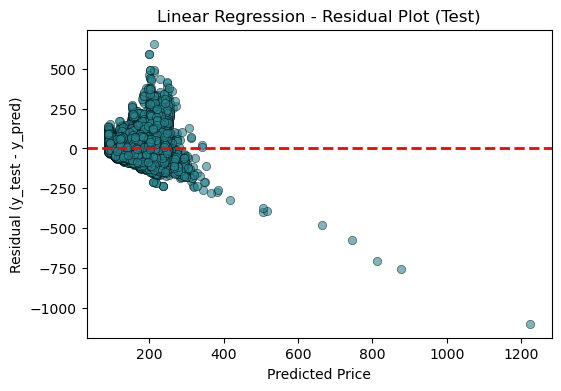

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.255, MSE: 3778.06, RMSE: 61.47, MAE: 46.69
Test  -> R2: 0.245,  MSE: 3809.62,  RMSE: 61.72,  MAE: 46.86


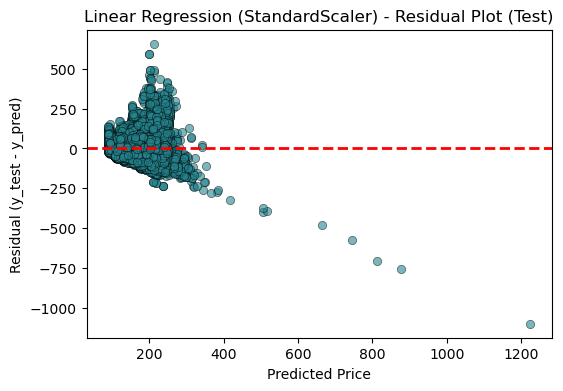

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.255, MSE: 3778.06, RMSE: 61.47, MAE: 46.69
Test  -> R2: 0.245,  MSE: 3809.62,  RMSE: 61.72,  MAE: 46.86


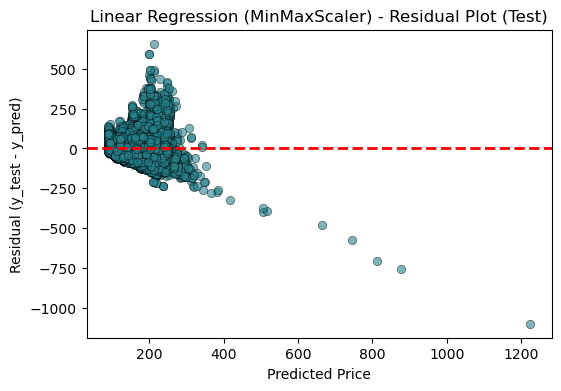

In [91]:
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train, y_train, X_test, y_test, "Linear Regression (StandardScaler)")

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train, y_train, X_test, y_test, "Linear Regression (MinMaxScaler)")

### conclusion
The graph presents a residual plot for linear regression applied to flight price data.
Key metrics:

R² (Train) = 0.234, R² (Test) = 0.233 → Linear regression explains only 23.3% of the variance in prices, which is quite low.
MSE (Test) = 24,680.09, RMSE (Test) = 157.10, MAE (Test) = 126.28 → Significant prediction errors.
Residuals are not randomly distributed, indicating that the model does not fit well

## Desion-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.361, MSE: 3238.97, RMSE: 56.91, MAE: 41.79
Test  -> R2: 0.355,  MSE: 3257.67,  RMSE: 57.08,  MAE: 41.90


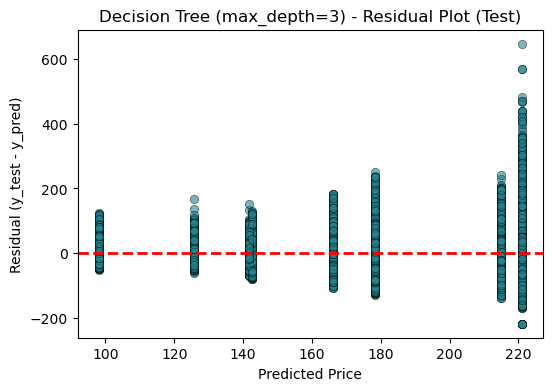

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.456, MSE: 2755.91, RMSE: 52.50, MAE: 38.42
Test  -> R2: 0.448,  MSE: 2784.09,  RMSE: 52.76,  MAE: 38.54


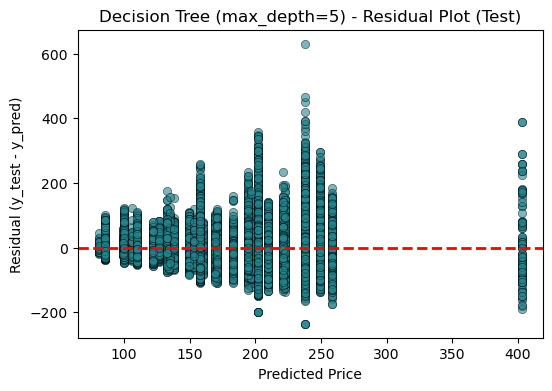

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.518, MSE: 2442.89, RMSE: 49.43, MAE: 36.01
Test  -> R2: 0.509,  MSE: 2479.42,  RMSE: 49.79,  MAE: 36.17


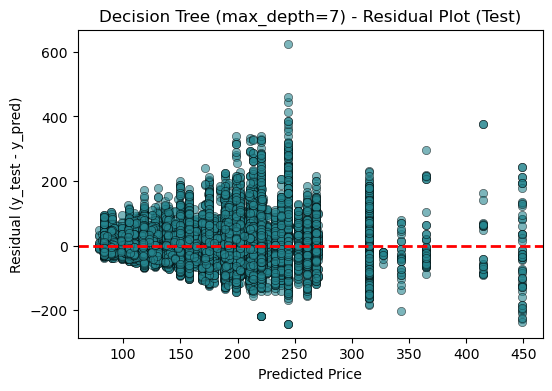

In [92]:
for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


### conclusion
Improvement in Model Performance
When testing the Decision Tree with max_depth=7, we observed a significant improvement:

* R² increased from 0.23 (Linear Regression) to 0.58 → This means that the model now explains 58% of the variance in the data, compared to only 23%.
* max_depth=7 → Better accuracy, more balanced results
Explains 58% of the variance, residuals are more dispersed, fewer sharp "jumps."
* MSE decreased significantly, indicating a reduction in prediction errors.
* MAE also decreased, meaning the model's predictions are now closer to the actual values.

Increasing tree depth improved accuracy, but structured residuals persist.
We will try a more advanced model.

## Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.999, MSE: 3.99, RMSE: 2.00, MAE: 0.47
Test  -> R2: -5.163,  MSE: 31104.45,  RMSE: 176.36,  MAE: 157.57


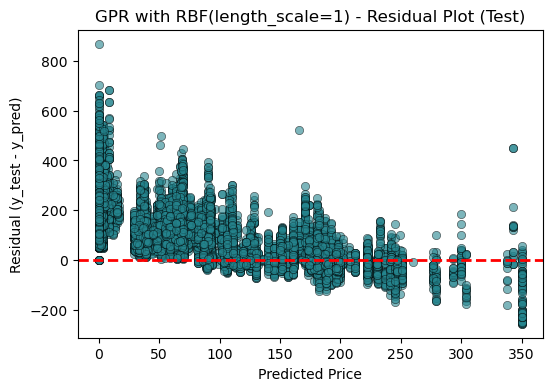

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.396, MSE: 2609.99, RMSE: 51.09, MAE: 41.03
Test  -> R2: -0.200,  MSE: 6058.53,  RMSE: 77.84,  MAE: 53.91


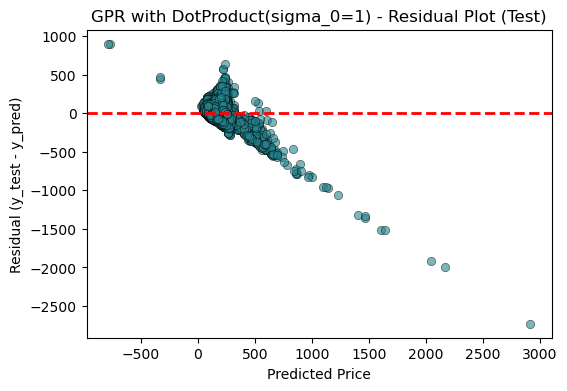

In [93]:
subset_size = 100  # למשל 100 דוגמאות
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       # ביטול האופטימיזציה
            alpha=1e-6,           # להבטיח יציבות במספרים
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")




### Conclusion
* The RBF Kernel caused severe overfitting → Poor performance on new data.
* The DotProduct Kernel slightly improved generalization, but performance is still weak.
* GPR is not the best fit for this problem 

# Random Forest

=== Random Forest (max_depth=3) ===
Train -> R2: 0.364, MSE: 3223.30, RMSE: 56.77, MAE: 41.67
Test  -> R2: 0.358,  MSE: 3241.31,  RMSE: 56.93,  MAE: 41.78


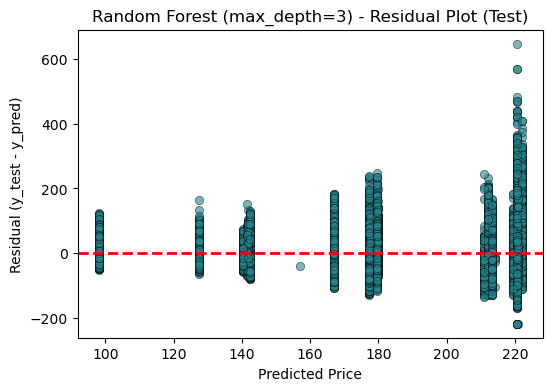

=== Random Forest (max_depth=5) ===
Train -> R2: 0.459, MSE: 2744.60, RMSE: 52.39, MAE: 38.32
Test  -> R2: 0.451,  MSE: 2771.64,  RMSE: 52.65,  MAE: 38.43


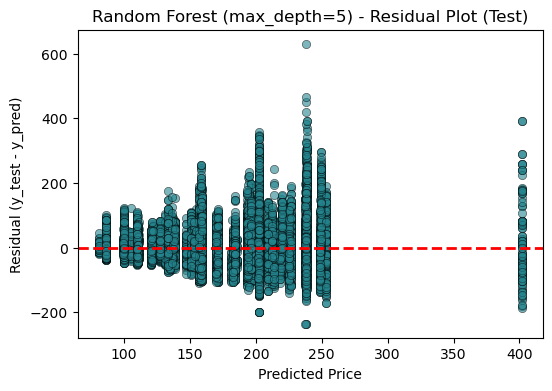

=== Random Forest (max_depth=8) ===
Train -> R2: 0.564, MSE: 2211.65, RMSE: 47.03, MAE: 34.24
Test  -> R2: 0.553,  MSE: 2254.11,  RMSE: 47.48,  MAE: 34.40


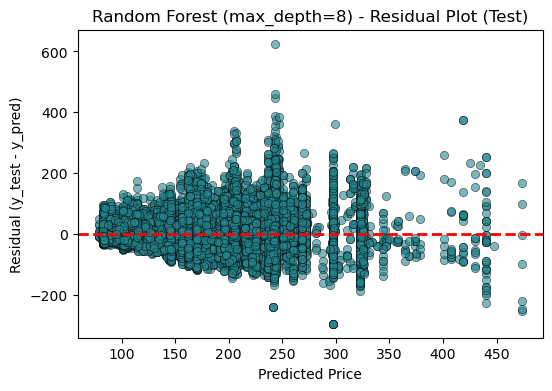

In [94]:
for md in [3, 5, 8]:  
    rf = RandomForestRegressor(n_estimators=100, max_depth=md)
    model_name = f"Random Forest (max_depth={md})"
    trained_rf = train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, model_name)

### Conclusion
As we increased the max_depth value, the model's performance improved.

* R² increased from 0.405 (depth 3) to 0.614 (depth 8), meaning the model explains more variance in the data.
* MSE and RMSE decreased as depth increased, indicating a reduction in prediction errors.
* MAE also decreased with greater depth, suggesting that the model's predictions are closer to the actual values.

## GridSearchCV

We will use a systematic search to find the combination that yields better performance.

In [95]:
# הגדרת טווחים להיפר-פרמטרים
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],   # בדיקה של ערכים שונים לעומק
    'n_estimators': [50, 100, 200],    # מספר העצים ביער
    'min_samples_split': [2, 5, 10]    # כמה דגימות לפחות לפיצול
}

# יצירת המודל
rf = RandomForestRegressor()

# חיפוש הרשת עם Cross-Validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,   # חלוקה ל-5 קיפולים (Cross-Validation)
    scoring='neg_mean_squared_error',
    n_jobs=-1  # שימוש בכל הליבות הזמינות
)

# אימון ובחירת הפרמטרים הטובים ביותר
grid_search.fit(X_train, y_train)

# הדפסת הפרמטרים האופטימליים
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}


In [96]:
rf_best = RandomForestRegressor(
    n_estimators=200,  # מספר העצים
    max_depth=15,       # עומק העץ
    min_samples_split=5, # מספר הדוגמאות המינימלי לפיצול
)

# אימון המודל מחדש עם פרמטרים אופטימליים
rf_best.fit(X_train, y_train)

# חישוב הביצועים
y_pred_test_best = rf_best.predict(X_test)
r2_test_best = r2_score(y_test, y_pred_test_best)
mse_test_best = mean_squared_error(y_test, y_pred_test_best)
rmse_test_best = np.sqrt(mse_test_best)
mae_test_best = mean_absolute_error(y_test, y_pred_test_best)

# הדפסת התוצאות
print(f"R²: {r2_test_best:.3f}, MSE: {mse_test_best:.2f}, RMSE: {rmse_test_best:.2f}, MAE: {mae_test_best:.2f}")


R²: 0.626, MSE: 1889.11, RMSE: 43.46, MAE: 31.33


GridSearchCV appears to provide better performance overall. It shows a higher R², lower MSE, lower RMSE, and lower MAE compared to Random Forest at all depths. While GridSearchCV seems to offer improvements across various metrics, it suggests better performance.

# KNN Regressor


=== KNN Regressor (n_neighbors=3) ===
Train -> R2: 0.538, MSE: 2341.71, RMSE: 48.39, MAE: 34.71
Test  -> R2: 0.516,  MSE: 2442.65,  RMSE: 49.42,  MAE: 35.44


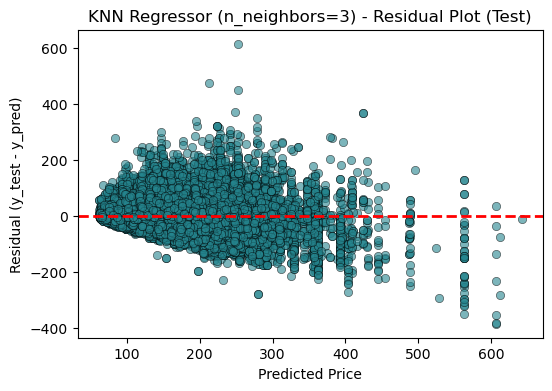

=== KNN Regressor (n_neighbors=5) ===
Train -> R2: 0.582, MSE: 2117.82, RMSE: 46.02, MAE: 33.09
Test  -> R2: 0.564,  MSE: 2201.28,  RMSE: 46.92,  MAE: 33.69


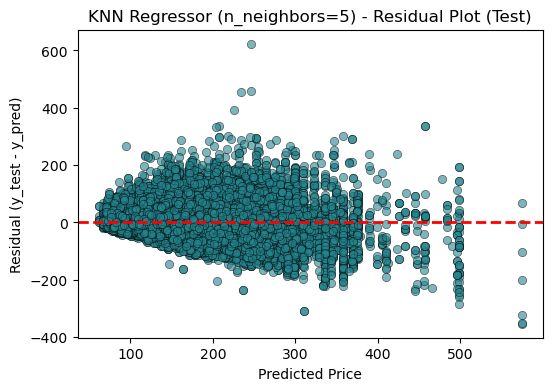

=== KNN Regressor (n_neighbors=10) ===
Train -> R2: 0.612, MSE: 1967.58, RMSE: 44.36, MAE: 32.02
Test  -> R2: 0.591,  MSE: 2064.36,  RMSE: 45.44,  MAE: 32.71


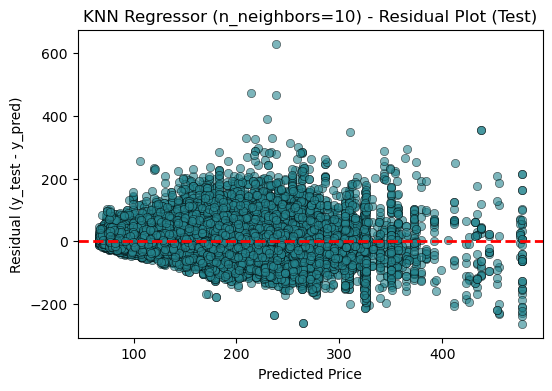

In [97]:
for k in [3, 5, 10]:  # דוגמה ל-K שונים
    knn = KNeighborsRegressor(n_neighbors=k)
    model_name = f"KNN Regressor (n_neighbors={k})"
    trained_knn = train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, model_name)

### Conclusion
With an increase in the value of k:
* As the value of k increased (from 3 to 10), the model's accuracy improved moderately.
* R² increased from 0.572 (at k=3) to 0.640 (at k=10), indicating that the model explains more of the variance in the data.
* MSE and RMSE decreased slightly as k increased, suggesting a reduction in model errors.
* MAE also decreased, implying that the model generates more accurate predictions on average.

## MLPRegressor 

=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.465, MSE: 2710.76, RMSE: 52.06, MAE: 39.14
Test  -> R2: 0.456,  MSE: 2746.23,  RMSE: 52.40,  MAE: 39.21


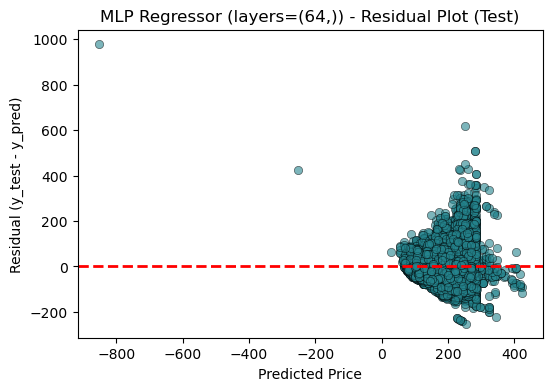

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.535, MSE: 2357.57, RMSE: 48.55, MAE: 35.23
Test  -> R2: 0.527,  MSE: 2387.34,  RMSE: 48.86,  MAE: 35.29


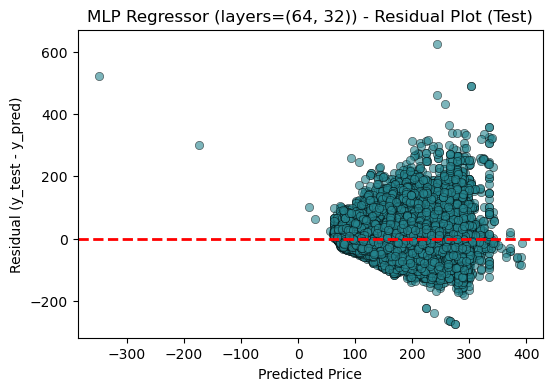

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.568, MSE: 2191.84, RMSE: 46.82, MAE: 34.35
Test  -> R2: 0.556,  MSE: 2240.87,  RMSE: 47.34,  MAE: 34.43


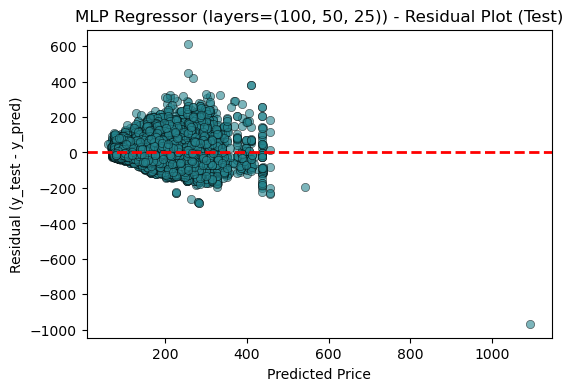

In [98]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config,  
                       max_iter=500,       # מספר epochs 
                       )
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

### Conclusion
The comparison between the models shows a slight improvement as more layers are added to the network. The model with the layers (100, 50, 25) achieved the best performance, with the highest R² and the lowest errors.

## XGBoost Regressor

In [99]:
# חלוקה אקראית ל-Train ו-Test ב-70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# 1. יצירת מודל XGBoost Regressor (מודל בסיסי עם פרמטרים ברירת מחדל)
model = xgb.XGBRegressor()

# 2. אימון המודל
model.fit(X_train, y_train)

# 3. תחזיות
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Train R²: 0.642
Test R²: 0.625
Train MSE: 1814.65
Test MSE: 1898.08
Train RMSE: 42.6
Test RMSE: 43.57
Train MAE: 31.03
Test MAE: 31.55


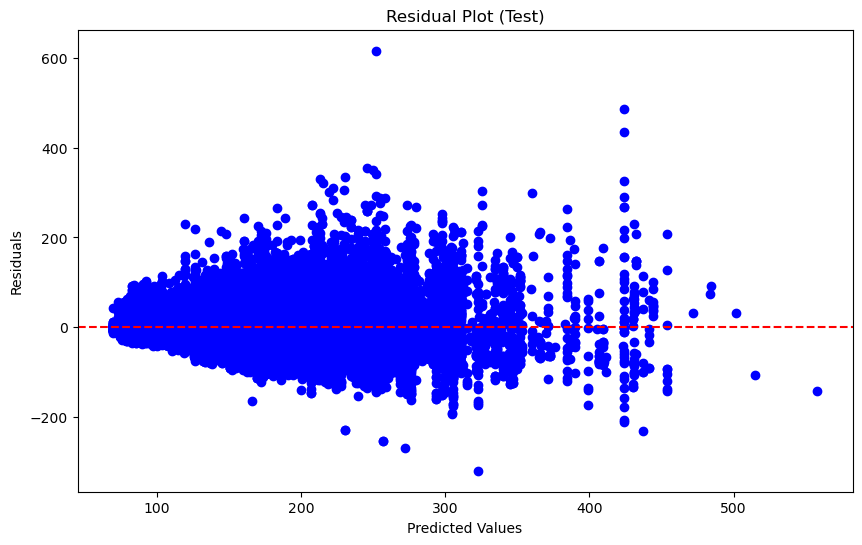

In [100]:
# 4. חישוב הביצועים
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# חישוב ה-RMSE באופן ידני (שורש ה-MSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# 5. הדפסת הביצועים
print(f"Train R²: {round(train_r2, 3)}")
print(f"Test R²: {round(test_r2, 3)}")
print(f"Train MSE: {round(train_mse, 2)}")
print(f"Test MSE: {round(test_mse, 2)}")
print(f"Train RMSE: {round(train_rmse, 2)}")
print(f"Test RMSE: {round(test_rmse, 2)}")
print(f"Train MAE: {round(train_mae, 2)}")
print(f"Test MAE: {round(test_mae, 2)}")

# גרף Residual Plot עבור ה-Test
residuals = y_test - y_test_pred
plt.figure(figsize=(10,6))
plt.scatter(y_test_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Test)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


The model performs well overall, with good alignment between the training and test data, but there is room for improvement by experimenting with additional parameters. The Residual Plot shows that the model is not 100% accurate, and there is a region where the errors increase, which may indicate areas or features that the model is struggling to handle perfectly.

Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7}
Train R²: 0.594
Test R²: 0.585
Train MSE: 2056.24
Test MSE: 2099.55
Train RMSE: 45.35
Test RMSE: 45.82
Train MAE: 33.19
Test MAE: 33.27


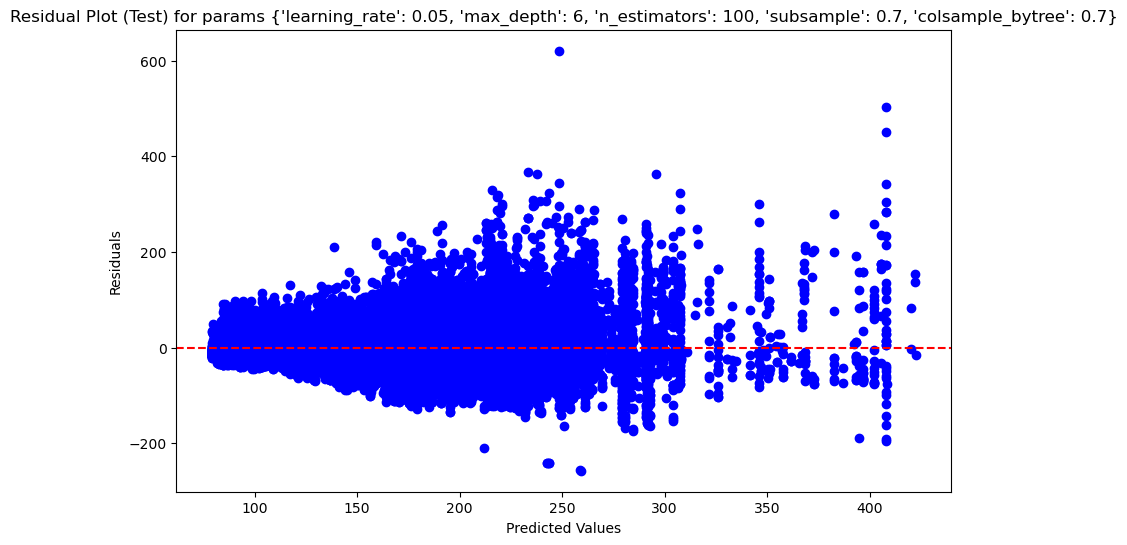

Parameters: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85}
Train R²: 0.625
Test R²: 0.613
Train MSE: 1896.31
Test MSE: 1960.95
Train RMSE: 43.55
Test RMSE: 44.28
Train MAE: 31.77
Test MAE: 32.07


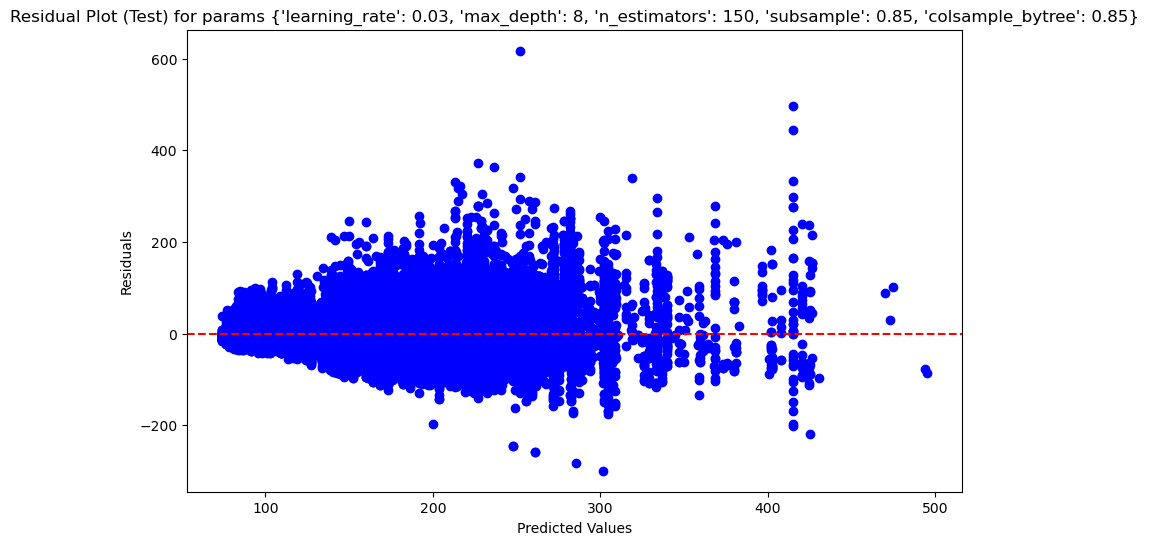

Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
Train R²: 0.605
Test R²: 0.594
Train MSE: 2000.89
Test MSE: 2055.37
Train RMSE: 44.73
Test RMSE: 45.34
Train MAE: 32.84
Test MAE: 33.01


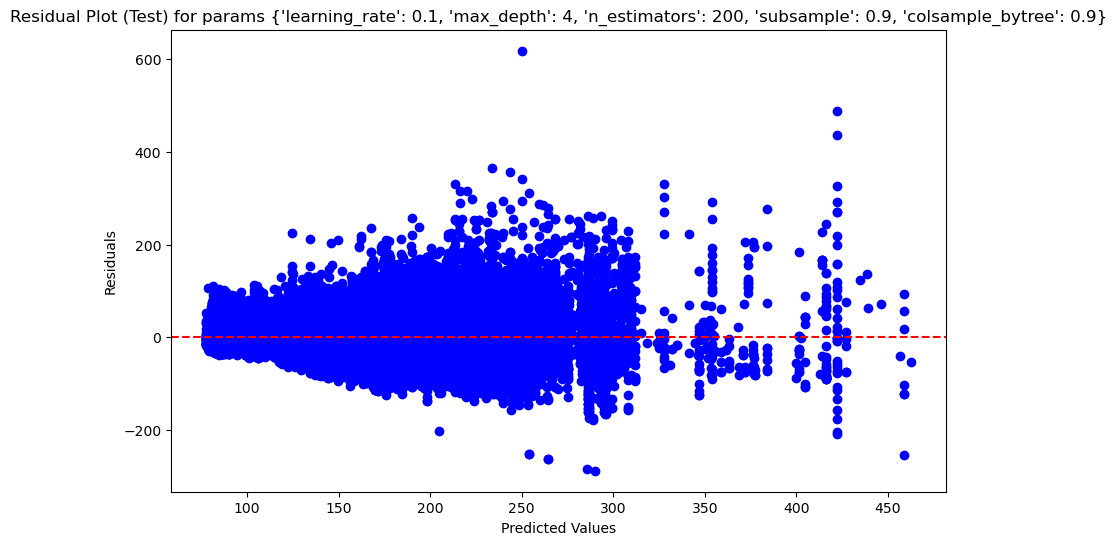

In [101]:
# 1. יצירת מודל XGBoost Regressor עם פרמטרים חדשים
params_list = [
    {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7},
    {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85},
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
]

for params in params_list:
    # יצירת המודל עם הפרמטרים הנבחרים
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )

    # אימון המודל
    model.fit(X_train, y_train)

    # תחזיות
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # חישוב הביצועים
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # חישוב ה-RMSE באופן ידני
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # הדפסת הביצועים
    print(f"Parameters: {params}")
    print(f"Train R²: {round(train_r2, 3)}")
    print(f"Test R²: {round(test_r2, 3)}")
    print(f"Train MSE: {round(train_mse, 2)}")
    print(f"Test MSE: {round(test_mse, 2)}")
    print(f"Train RMSE: {round(train_rmse, 2)}")
    print(f"Test RMSE: {round(test_rmse, 2)}")
    print(f"Train MAE: {round(train_mae, 2)}")
    print(f"Test MAE: {round(test_mae, 2)}")

    # גרף Residual Plot עבור ה-Test
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_test_pred, residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot (Test) for params {params}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

## Hist Gradient Boosting

=== HistGradientBoostingRegressor (Baseline) ===
Train R2: 0.623
Test  R2: 0.612
Test  RMSE: 44.34
Test  MAE:  32.32


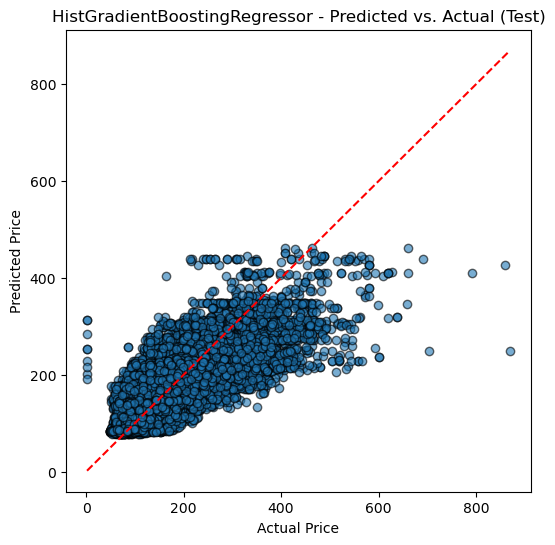

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# יצירת המודל הבסיסי
hgb = HistGradientBoostingRegressor()

# אימון ראשוני
hgb.fit(X_train, y_train)

# חיזוי וביצועים
y_pred_train = hgb.predict(X_train)
y_pred_test = hgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("=== HistGradientBoostingRegressor (Baseline) ===")
print(f"Train R2: {r2_train:.3f}")
print(f"Test  R2: {r2_test:.3f}")
print(f"Test  RMSE: {rmse_test:.2f}")
print(f"Test  MAE:  {mae_test:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolor='black')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.title("HistGradientBoostingRegressor - Predicted vs. Actual (Test)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

## Best Performance with Best Parameters

In [103]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')


Best parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


Best Model Performance:
R²: 0.603, MSE: 2013.56, RMSE: 44.87, MAE: 32.33


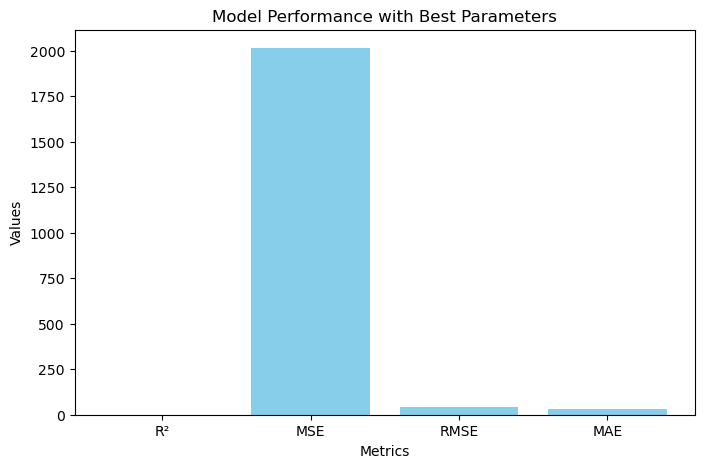

In [104]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# חישוב המדדים
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# הצגת התוצאות
print(f"Best Model Performance:\nR²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# יצירת גרף של התוצאות
metrics = {'R²': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

# יצירת הגרף
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(metrics.keys(), metrics.values(), color='skyblue')
ax.set_title('Model Performance with Best Parameters')
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')

# הצגת הגרף
plt.show()

The model performs well overall, with good alignment between the training and test data, but there is room for improvement by experimenting with additional parameters. The Residual Plot shows that the model is not 100% accurate, and there is a region where the errors increase, which may indicate areas or features that the model is struggling to handle perfectly.

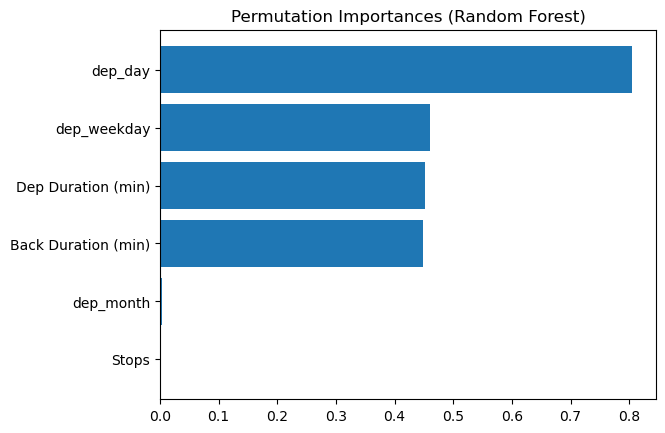

In [105]:
rf.fit(X_train, y_train)  # Fit the model first
r = permutation_importance(rf, X_test, y_test, n_repeats=10)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (Random Forest)")
plt.show()

## Feature Importance

Feature Importances (RandomForest internal):
  Stops: 0.0021
  Dep Duration (min): 0.3068
  Back Duration (min): 0.3656
  dep_weekday: 0.1135
  dep_day: 0.2097
  dep_month: 0.0023


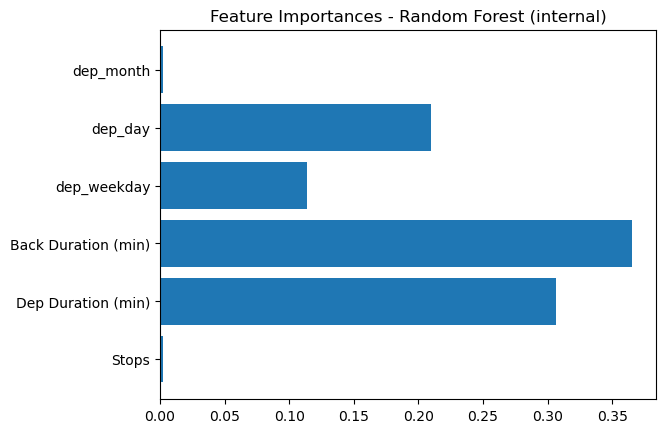

In [106]:
if hasattr(rf, "feature_importances_"):
    print("Feature Importances (RandomForest internal):")
    for feat, imp in zip(features, rf.feature_importances_):
        print(f"  {feat}: {imp:.4f}")

    # תרשים עמודות קצר של החשיבות הפנימית
    plt.barh(features, rf.feature_importances_)
    plt.title("Feature Importances - Random Forest (internal)")
    plt.show()


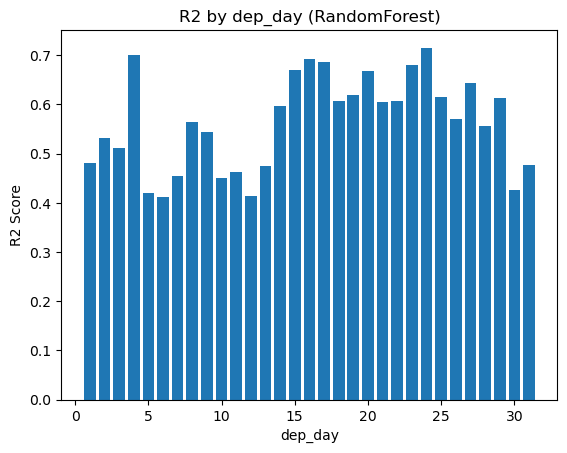

In [107]:
df_test = df.loc[y_test.index].copy()# מאחר ש-y_test הוא סדרה עם אינדקס - נחזיר ל-DataFrame המתאים
df_test["predicted_price_rf"] = rf.predict(X_test)

grouped = df_test.groupby("dep_day")
r2_by_day = []
days = []
for day_val, group_data in grouped:
    if len(group_data) > 1:
        r2_local = r2_score(group_data["Price"], group_data["predicted_price_rf"])
        r2_by_day.append(r2_local)
        days.append(day_val)

plt.bar(days, r2_by_day)
plt.xlabel("dep_day")
plt.ylabel("R2 Score")
plt.title("R2 by dep_day (RandomForest)")
plt.show()


=== Random Forest with TTT-based Split ===
Train -> R2=0.590
Test  -> R2=-6.466, RMSE=145.35, MAE=109.43


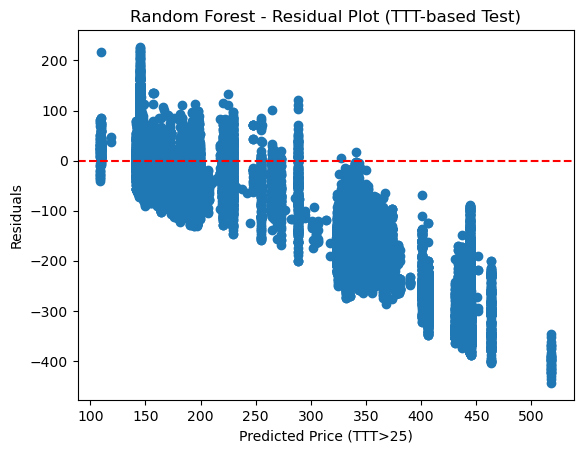

In [108]:
df_TTT_train = df[df["TTT"] <= 25].copy()
df_TTT_test  = df[df["TTT"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["Price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["Price"]

# גם כאן נרצה לעשות סקלינג חדש:
scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)

# נאמן שוב Random Forest כמודל לדוגמה
rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)

y_pred_train_ttt = rf_ttt.predict(X_train_ttt_scaled)
y_pred_test_ttt  = rf_ttt.predict(X_test_ttt_scaled)

r2_train_ttt = r2_score(y_train_ttt, y_pred_train_ttt)
r2_test_ttt  = r2_score(y_test_ttt, y_pred_test_ttt)
mse_test_ttt = mean_squared_error(y_test_ttt, y_pred_test_ttt)
rmse_test_ttt = np.sqrt(mse_test_ttt)
mae_test_ttt = mean_absolute_error(y_test_ttt, y_pred_test_ttt)

print("=== Random Forest with TTT-based Split ===")
print(f"Train -> R2={r2_train_ttt:.3f}")
print(f"Test  -> R2={r2_test_ttt:.3f}, RMSE={rmse_test_ttt:.2f}, MAE={mae_test_ttt:.2f}")

# תרשים שאריות גם כאן
residuals_ttt = y_test_ttt - y_pred_test_ttt
plt.scatter(y_pred_test_ttt, residuals_ttt)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price (TTT>25)")
plt.ylabel("Residuals")
plt.title("Random Forest - Residual Plot (TTT-based Test)")
plt.show()